<a href="https://colab.research.google.com/github/thayeylolu/cyberbullying/blob/main/notebooks/the_multiclass_text_classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORTS 

In [1]:
!pip install torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 5.1 MB/s 
     |████████████████████████████████| 831.4 MB 2.7 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.


In [2]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import scikitplot as skplt
import random
import time
import pandas as pd
import numpy as np
import re
import os 
import torch
import torch.nn as nn
import torch.optim as optim
import plotly.express as px
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
# cross validation and metrics
from torch.optim.optimizer import Optimizer
from multiprocessing import  Pool



### Mount Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Url to data

In [5]:
url = "/content/drive/MyDrive/NLP/train_data.csv"
#url = "train_data.csv"

### Load and Split Data

In [6]:
df = pd.read_csv(url)
df = df.dropna()
df = df[['cyberbullying_type', 'clean_txt_emoji']]

train, test_valid = train_test_split(df,train_size= 0.70, random_state= 3040)
test, valid = train_test_split(test_valid,train_size= .50, random_state= 3040)


### Basic Parameters

In [7]:
np.random.seed(3040)
random.seed(3040)
torch.manual_seed(3040) 

### Prepare Data For DataLoading and Tokenization

In [8]:
train_X, train_y = train['clean_txt_emoji'].to_list(), train['cyberbullying_type'].to_list()
test_X, test_y = test['clean_txt_emoji'].to_list(), test['cyberbullying_type'].to_list()
valid_X, valid_y = valid['clean_txt_emoji'].to_list(), valid['cyberbullying_type'].to_list()

train_dat =list(zip(train_y,train_X))
valid_dat =list(zip(valid_y,valid_X))
test_dat=list(zip(test_y,test_X))

In [9]:
import math
embed_size = 300 #() how big is each word vector
max_features = math.trunc(len(list( train['clean_txt_emoji'].str.split(' ', expand=True).stack().unique())))/2 # the unique words divided by 2 because some words could occur once
maxlen = 750 # max number of words 
batch_size = 512 # how many samples to process at once
n_epochs = 5 # how many times to iterate over all samples
n_splits = 5 # Number of K-fold Splits
SEED = 3040
debug = 0

In [10]:
max_features = math.trunc(max_features)

In [11]:
max_features

16692

In [12]:
df.sample(3)

,cyberbullying_type,clean_txt_emoji
46249,ethnicity,course this dumb nigger gonna get front even t...
23609,religion,say not hate islam dumb saying not hate nazism
7225,not_cyberbullying,cuando encerraban armario daban vueltas hasta ...


In [13]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))

train_X = tokenizer.texts_to_sequences(train_X)
test_X = tokenizer.texts_to_sequences(test_X)
valid_X = tokenizer.texts_to_sequences(valid_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)
valid_X = pad_sequences(valid_X, maxlen=maxlen)

In [14]:
max_features

16692

### Encode Label(CyberBullying Type) to numbers

In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(train_y)
test_y = le.transform(test_y)
valid_y = le.transform(valid_y)

### Load Embeddings


In [16]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip glove*.zip
!ls
!pwd

import zipfile
with zipfile.ZipFile('glove.840B.300d.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/NLP/')

### Function to Embed Data

In [17]:
## FUNCTIONS TAKEN FROM https://www.kaggle.com/gmhost/gru-capsule

def load_glove(word_index, embed_size):
  np.random.seed(3040)
  random.seed(3040)
  torch.manual_seed(3040) 
    EMBEDDING_FILE = '/content/drive/MyDrive/NLP/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:embed_size]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

### Embed Vectors

In [18]:
max_features

16692

In [19]:
# missing entries in the embedding are set using np.random.normal so we have to seed here too

if debug:
    embedding_matrix = np.random.randn(max_features, embed_size)
else:
    embedding_matrix = load_glove(tokenizer.word_index, embed_size)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [20]:
np.shape(embedding_matrix)

(16692, 300)

## Pytorch Model - TextCNN

Initializing the`Text CNN` 
- Create a list of kernel with different window sizes to be used during convultion
- Initialize Embedding Layer's weight by generating parameters from `embedding_matrix` created earlier
- `self.embedding.weight.requires_grad` is set to False because we dont want to train the embeddings weights during model training

- Input channel of 1,  non-square kernels and an output channel of `num_filters`
- We generated several convolution layers each having different kernel(filter) and stored  layers in a Module list
-  We set a dropout of 0.1 
- We finally created a fully connected network by passing the parameters to the last layer which is a linear layer< output layer>




In [21]:
### https://www.kaggle.com/code/mlwhiz/multiclass-text-classification-pytorch/notebook
class CNN_Text(nn.Module):
    
    def __init__(self):
        super(CNN_Text, self).__init__()
        filter_sizes = [1,2,3,5]
        num_filters = 36
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)


    def forward(self, x):
        x = self.embedding(x)  
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x) 
        return logit

## Train TextCNN Model

In [25]:
## adopted from https://www.kaggle.com/code/mlwhiz/multiclass-text-classification-pytorch/notebook
np.random.seed(3040)
random.seed(3040)
torch.manual_seed(3040) 

model = CNN_Text()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()

x_cv = torch.tensor(valid_X, dtype=torch.long).cuda()
y_cv = torch.tensor(valid_y, dtype=torch.long).cuda()

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.0  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==valid_y)/len(valid_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/5 	 loss=415.6418 	 val_loss=241.2593  	 val_acc=0.8142  	 time=193.84s
Epoch 2/5 	 loss=237.2924 	 val_loss=208.6207  	 val_acc=0.8401  	 time=193.86s
Epoch 3/5 	 loss=207.9939 	 val_loss=191.6133  	 val_acc=0.8523  	 time=193.61s
Epoch 4/5 	 loss=190.7469 	 val_loss=186.7787  	 val_acc=0.8547  	 time=193.36s
Epoch 5/5 	 loss=177.9750 	 val_loss=182.3351  	 val_acc=0.8558  	 time=194.97s


In [26]:
torch.save(model,'textcnn_model')

In [27]:
### adopted from https://www.kaggle.com/code/mlwhiz/multiclass-text-classification-pytorch/notebook

def plot_graph(epochs):
    fig = plt.figure(figsize=(12,12))
    plt.title("Train/Validation Loss")
    plt.plot(list(np.arange(epochs) + 1) , train_loss, label='train')
    plt.plot(list(np.arange(epochs) + 1), valid_loss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)
    plt.legend(loc='best')

### Train Val Loss CUrve

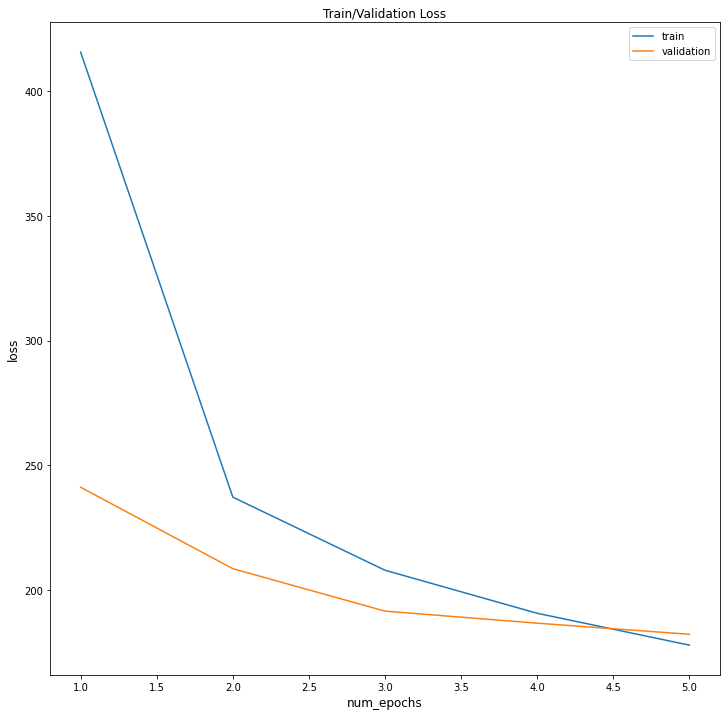

In [28]:
plot_graph(n_epochs)

### Confusion Matrix

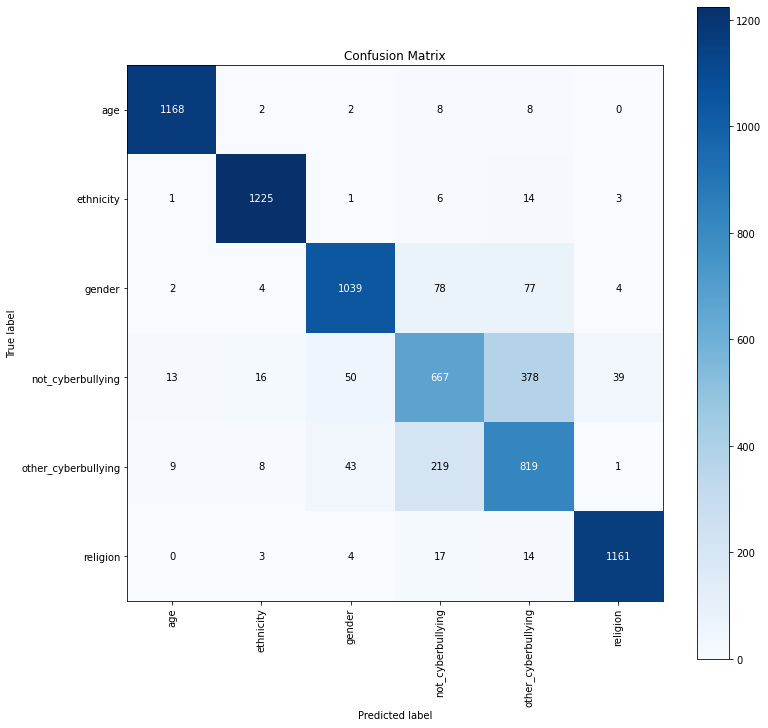

In [29]:

y_true = [le.classes_[x] for x in valid_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

## Deploy : Predict A Single Example CNN

In [33]:
def predict_single(x):    
    x = tokenizer.texts_to_sequences([x])
    # pad
    x = pad_sequences(x, maxlen=maxlen)
    # create dataset
    x = torch.tensor(x, dtype=torch.long).cuda()

    pred = model(x).detach()
    pred = F.softmax(pred).cpu().numpy()

    pred = pred.argmax(axis=1)

    pred = le.classes_[pred]
    return pred[0]


test['cnn_txt'] = test['clean_txt_emoji'].apply(lambda x:predict_single(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


In [35]:
test

,cyberbullying_type,clean_txt_emoji,cnn_txt
9465,gender,not sexist but woman head teacher isnt physica...,gender
31886,age,was bullied school too wrote song just like yo...,age
10936,gender,doesn everyone call their female colleagues fu...,gender
2611,not_cyberbullying,would not fair kat knows nothing fair wtf hypo...,gender
46625,ethnicity,told you jaycen not just dumb nigger very gift...,ethnicity
...,...,...,...
42623,ethnicity,fuck obama dumb nigger bullshit electric cars ...,ethnicity
9757,gender,thicke txlege rape jokes harassment our cultur...,gender
40304,ethnicity,how can you say niggers are ugly girl make sin...,ethnicity
3853,not_cyberbullying,interesting tho that still found most them,not_cyberbullying


In [37]:
from sklearn.metrics import accuracy_score
accuracy_score = accuracy_score(test.cyberbullying_type, test.cnn_txt)
accuracy_score

0.8406082793579274

## Pytorch Model - BiLSTM

## Pytorch Model - BiLSTM

Initializing the`BiLSTM` 

- set the hidden size to 64 and a drop out to 0.1
- Initialize Embedding Layer's weight by generating parameters from `embedding_matrix` created earlier
- `self.embedding.weight.requires_grad` is set to False because we dont want to train the embeddings.
- Defing the LSTM model and set the  bidirectional=True and batch_first=True. To use a bidirecitonal lstm and to process that data in batches respectively.


In the forward pass, we set the hidden state as the embedding, we make the second hidden state the lstm model. We gnenrate the average and max pool for the second hidden state. We connect it to the a RELU, whuch is then connected to a drop, the findally, the output layer

In [38]:
## code adopted from https://www.kaggle.com/code/mlwhiz/multiclass-text-classification-pytorch/notebook

class BiLSTM(nn.Module):
    
    def __init__(self):
        super(BiLSTM, self).__init__()
        self.hidden_size = 64
        drp = 0.1
        n_classes = len(le.classes_)
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drp)
        self.out = nn.Linear(64, n_classes)


    def forward(self, x):
        #rint(x.size())
        h_embedding = self.embedding(x)
        #_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

In [40]:
### https://www.kaggle.com/code/mlwhiz/multiclass-text-classification-pytorch/notebook
np.random.seed(3040)
random.seed(3040)
torch.manual_seed(3040) 

model = BiLSTM()
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
model.cuda()

# Load train and test in CUDA Memory
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.long).cuda()
x_cv = torch.tensor(valid_X, dtype=torch.long).cuda()
y_cv = torch.tensor(valid_y, dtype=torch.long).cuda()
#
# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)
        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    val_accuracy = sum(val_preds.argmax(axis=1)==valid_y)/len(valid_y)
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f}  \t val_acc={:.4f}  \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_accuracy, elapsed_time))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/5 	 loss=599.5313 	 val_loss=269.0732  	 val_acc=0.7983  	 time=224.10s
Epoch 2/5 	 loss=256.6010 	 val_loss=212.6363  	 val_acc=0.8326  	 time=222.99s
Epoch 3/5 	 loss=220.5904 	 val_loss=197.4385  	 val_acc=0.8427  	 time=221.92s
Epoch 4/5 	 loss=203.5122 	 val_loss=188.1238  	 val_acc=0.8484  	 time=220.45s
Epoch 5/5 	 loss=192.4039 	 val_loss=183.9271  	 val_acc=0.8518  	 time=220.11s


### Train Val Loss CUrve

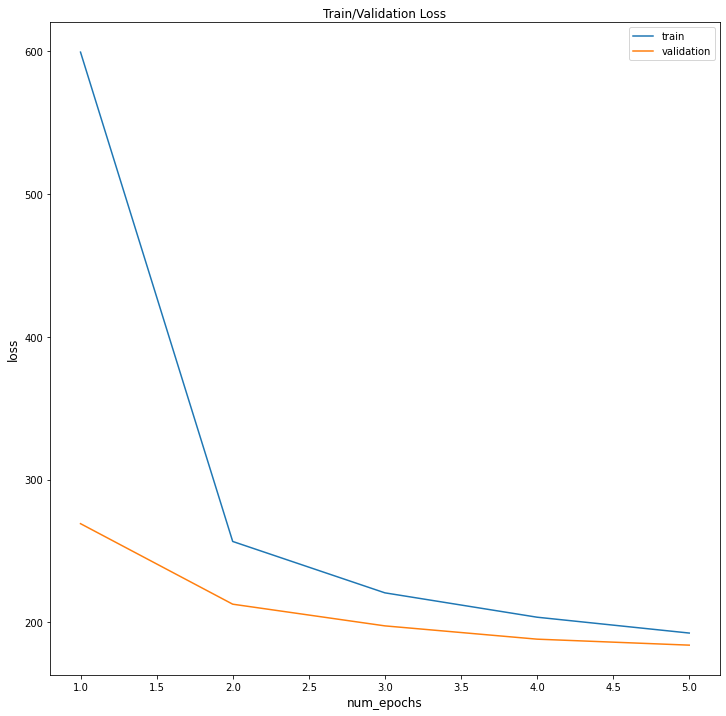

In [41]:
plot_graph(n_epochs)

In [42]:
torch.save(model,'bilstm_model')

### Confusion Matrix

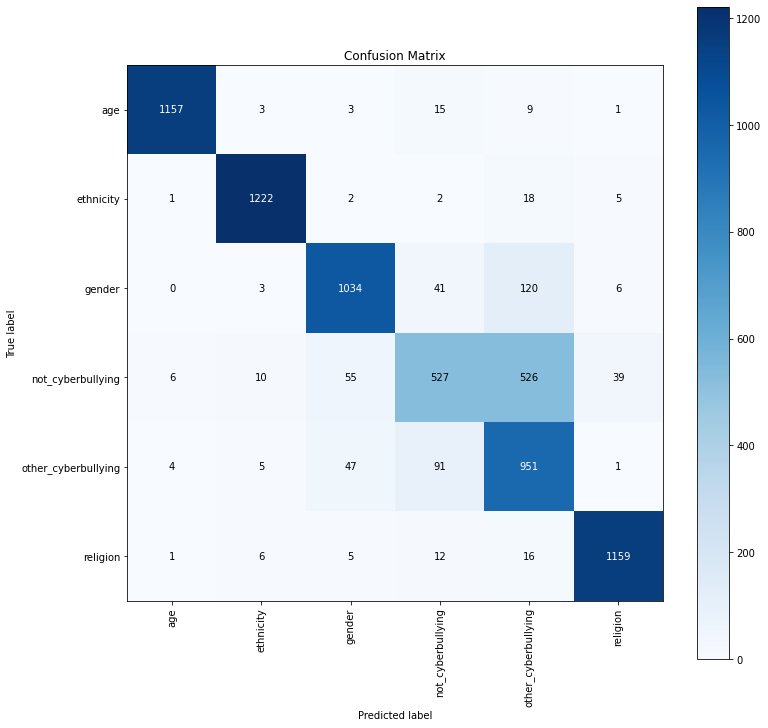

In [43]:
import scikitplot as skplt
y_true = [le.classes_[x] for x in valid_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]
skplt.metrics.plot_confusion_matrix(
    y_true, 
    y_pred,
    figsize=(12,12),x_tick_rotation=90)

## Deploy : Predict A Single Example

In [48]:
def predict_single(x):    
    x = tokenizer.texts_to_sequences([x])
    # pad
    x = pad_sequences(x, maxlen=maxlen)
    # create dataset
    x = torch.tensor(x, dtype=torch.long).cuda()

    pred = model(x).detach()
    pred = F.softmax(pred).cpu().numpy()

    pred = pred.argmax(axis=1)

    pred = le.classes_[pred]
    return pred[0]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


In [ ]:

test['bilstm_txt'] = test['clean_txt_emoji'].apply(lambda x:predict_single(x))

In [49]:
test

,cyberbullying_type,clean_txt_emoji,cnn_txt,bilstm_txt
9465,gender,not sexist but woman head teacher isnt physica...,gender,gender
31886,age,was bullied school too wrote song just like yo...,age,age
10936,gender,doesn everyone call their female colleagues fu...,gender,gender
2611,not_cyberbullying,would not fair kat knows nothing fair wtf hypo...,gender,gender
46625,ethnicity,told you jaycen not just dumb nigger very gift...,ethnicity,ethnicity
...,...,...,...,...
42623,ethnicity,fuck obama dumb nigger bullshit electric cars ...,ethnicity,ethnicity
9757,gender,thicke txlege rape jokes harassment our cultur...,gender,gender
40304,ethnicity,how can you say niggers are ugly girl make sin...,ethnicity,ethnicity
3853,not_cyberbullying,interesting tho that still found most them,not_cyberbullying,other_cyberbullying


In [55]:
test['cyberbullying_type'].unique()

array(['gender', 'age', 'not_cyberbullying', 'ethnicity',
       'other_cyberbullying', 'religion'], dtype=object)

### Get accuracy Score

In [56]:
from sklearn.metrics import accuracy_score
accuracy_score = accuracy_score(test['cyberbullying_type'], test['bilstm_txt'])
accuracy_score

0.8399042523232892